In [16]:
import numpy as np
import xarray as xr
import keras as ks
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Load data
ds = xr.open_dataset("New_CFSFebruari.nc", decode_times=False)

# Set global seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Extract variables
var1 = ds['Agustus'].values
var2 = ds['September'].values
var3 = ds['Oktober'].values
var14 = ds['AMH'].values

# Mask NaN values in var14
mask_nan_var14 = np.isnan(var14)

# Apply mask to the other variables
var1[mask_nan_var14] = np.nan
var2[mask_nan_var14] = np.nan
var3[mask_nan_var14] = np.nan

# Fill NaN values with median
median_valuejuni = np.nanmedian(var1)
median_valuejuli = np.nanmedian(var2)
median_valueagustus = np.nanmedian(var3)
median_valueamh = np.nanmedian(var14)

var1[np.isnan(var1)] = median_valuejuni
var2[np.isnan(var2)] = median_valuejuli
var3[np.isnan(var3)] = median_valueagustus
var14[np.isnan(var14)] = median_valueamh

data = np.stack([var1, var2, var3], axis=-1)

# Split data into predictors and target
predictors = data.reshape(data.shape[0]*data.shape[3], data.shape[1], data.shape[2], 1)
target = var14

# Normalisasi data prediktor dan target
scaler_x = MinMaxScaler()
data_reshaped = predictors.reshape(-1, predictors.shape[-1])
data_normalized = scaler_x.fit_transform(data_reshaped).reshape(predictors.shape)

scaler_y = MinMaxScaler()
target_reshaped = target.reshape(-1, 1)
target_normalized = scaler_y.fit_transform(target_reshaped).reshape(target.shape)

# Apply PCA to predictors
n_components = 0.97
pca = PCA(n_components=n_components)
data_flattened = data_normalized.reshape(-1, data_normalized.shape[3])
data_pca = pca.fit_transform(data_flattened)
data_pca = data_pca.reshape(data_normalized.shape[0], data_normalized.shape[1], data_normalized.shape[2], -1)

data_pca = data_pca[:90, :, :, :]
target_normalized = target_normalized[:30, :, :]
data_pca = data_pca.reshape(-1, 3, data_pca.shape[3])
target_normalized = target_normalized.reshape(-1)


# Define the optimal model configuration
layer_config = (16, 32)
dropout_rate = 0.5
learning_rate = 0.001
dense_size = 128
batch_size = 512

# Function to create model
def create_model():
    model = ks.Sequential([
        ks.layers.Input(shape=(data_pca.shape[1], data_pca.shape[2])),  # Specify the input shape using Input
        ks.layers.LSTM(layer_config[0], activation='tanh', return_sequences=True),
        ks.layers.BatchNormalization(),
        ks.layers.Dropout(dropout_rate),
        ks.layers.LSTM(layer_config[1], activation='tanh', return_sequences=False),
        ks.layers.BatchNormalization(),
        ks.layers.Dropout(dropout_rate),
        ks.layers.Dense(dense_size, activation='relu', kernel_regularizer=l2(0.1)),
        ks.layers.Dense(1, activation='sigmoid')
    ])   
    model.compile(optimizer=ks.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=False)
all_predictions = []
rmses = []
corrs = []
r2s = []

# Perform KFold cross-validation
for train_index, test_index in kf.split(data_pca):
    X_train, X_test = data_pca[train_index], data_pca[test_index]
    y_train, y_test = target_normalized[train_index], target_normalized[test_index]

    # Create and fit the model
    model = create_model()
    early_stopping = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    History = model.fit(X_train, y_train, batch_size=batch_size, epochs=300, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

    # Prediction
    y_pred = model.predict(X_test)
    y_pred = np.squeeze(y_pred)  # Flatten the predictions if needed

    all_predictions.extend(y_pred)

# Konversi list all_predictions ke numpy array untuk reshape
all_predictions_array = np.array(all_predictions)

7938/7938 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
predictions_denormalized = scaler_y.inverse_transform(all_predictions_array.reshape(-1, 1)).reshape(all_predictions_array.shape)
y_test_denormalized = scaler_y.inverse_transform(target_normalized.reshape(-1, 1)).reshape(target_normalized.shape)

rmse = np.sqrt(mean_squared_error(y_test_denormalized.flatten(), predictions_denormalized.flatten()))
r2 = r2_score(y_test_denormalized.flatten(), predictions_denormalized.flatten())
correlation_coefficient, _ = pearsonr(y_test_denormalized.flatten(), predictions_denormalized.flatten())

# Calculate MAPE using the filtered data
mape = mean_absolute_percentage_error(y_test_denormalized.flatten(), predictions_denormalized.flatten())


print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'Pearson Correlation Coefficient: {correlation_coefficient}')
print(f'MAPE:{mape*100}%')

RMSE: 24.910444989616085
R^2: 0.22108650291353693
Pearson Correlation Coefficient: 0.4715016175228315
MAPE:5.7080712462865675%


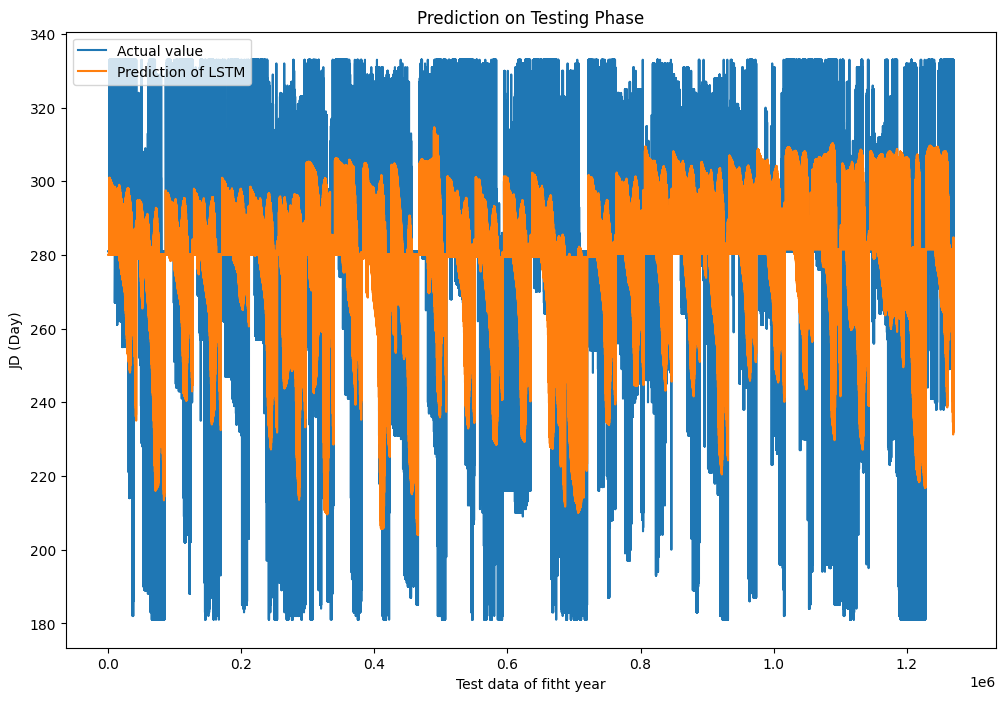

In [18]:
import matplotlib.pyplot as plt
predictions_denormalized_array = predictions_denormalized.reshape(-1)
#See the model performance on test dataset
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_test_denormalized, label='Actual value')
plt.plot(predictions_denormalized_array, label='Prediction of LSTM')
plt.legend(loc ="upper left")
plt.title('Prediction on Testing Phase')
plt.xlabel('Test data of fitht year')
plt.ylabel('JD (Day)')
plt.show()

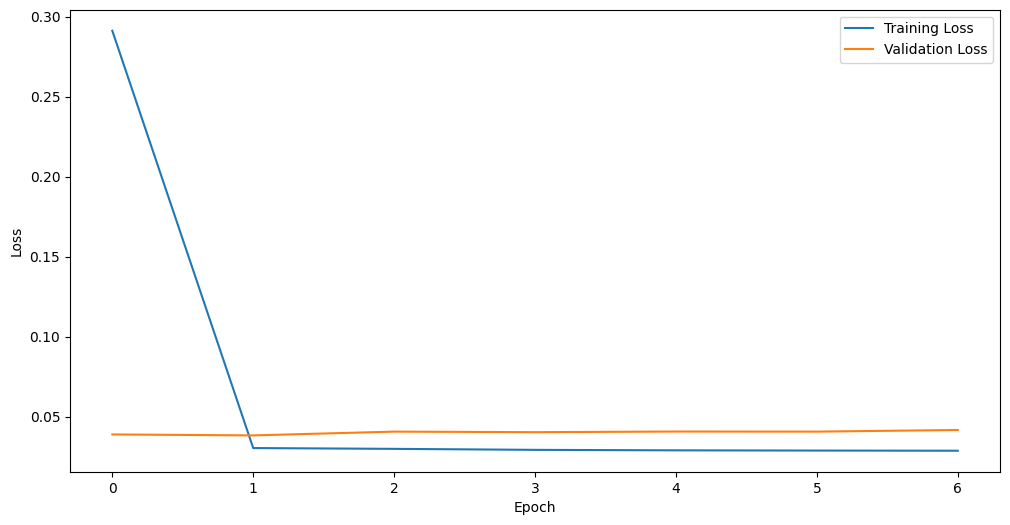

In [26]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
data = xr.open_dataset('AMH_with_NAN.nc')

mask_test = data['AMH'][:30,:,:]
mask_nan_var7 = np.isnan(mask_test)

Mask_prediksi = data['AMH'][-1,:,:]
mask_nan_prediksi = np.isnan(Mask_prediksi)

In [43]:
data = xr.open_dataset('AMH_with_NAN.nc')

mask_test = data['AMH'][:30,:,:]
mask_nan_var7 = np.isnan(mask_test)

Mask_prediksi = data['AMH'][-1,:,:]
mask_nan_prediksi = np.isnan(Mask_prediksi)
# Reshape predictions to match the original data shape
predicted_shape = (len(mask_test['year']), len(mask_test['latitude']), len(mask_test['longitude']))
full_predictions_reshaped = predictions_denormalized.reshape(predicted_shape)
# full_predictions_reshaped[mask_nan_var7] = np.nan
# Create xarray DataArray
predicted_da = xr.DataArray(
   data=full_predictions_reshaped,
   dims=["year", "latitude", "longitude"],
   coords={
       "year": mask_test['year'].values,
       "latitude": mask_test['latitude'].values,
       "longitude": mask_test['longitude'].values
   }
)

predicted_da.name = 'AMHp'
# Save to netCDF
predicted_da.to_netcdf("PreASO_Cansipv2Maret.nc")

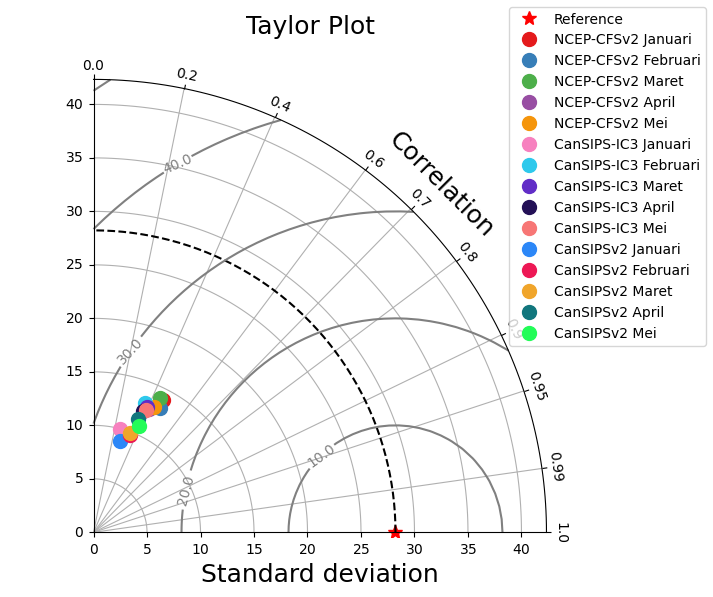

In [46]:
import numpy as np
import xarray as xr
from easy_mpl import taylor_plot

# Muat dataset observasi
data_observasi = xr.open_dataset('AMH_with_Median.nc')
obs_var = data_observasi['AMH'].values.flatten()

# Muat dataset prediksi untuk beberapa bulan
data_prediksi1 = xr.open_dataset('PreASO_CFSJanuari.nc')['AMHp'].values.flatten()
data_prediksi2 = xr.open_dataset('PreASO_CFSFebruari.nc')['AMHp'].values.flatten()
data_prediksi3 = xr.open_dataset('PreASO_CFSMaret.nc')['AMHp'].values.flatten()
data_prediksi4 = xr.open_dataset('PreASO_CFSApril.nc')['AMHp'].values.flatten()
data_prediksi5 = xr.open_dataset('PreASO_CFSMei.nc')['AMHp'].values.flatten()
data_prediksi6 = xr.open_dataset('PreASO_IC3Januari.nc')['AMHp'].values.flatten()
data_prediksi7 = xr.open_dataset('PreASO_IC3Februari.nc')['AMHp'].values.flatten()
data_prediksi8 = xr.open_dataset('PreASO_IC3Maret.nc')['AMHp'].values.flatten()
data_prediksi9 = xr.open_dataset('PreASO_IC3April.nc')['AMHp'].values.flatten()
data_prediksi10 = xr.open_dataset('PreASO_IC3Mei.nc')['AMHp'].values.flatten()
data_prediksi11 = xr.open_dataset('PreASO_Cansipv2Januari.nc')['AMHp'].values.flatten()
data_prediksi12 = xr.open_dataset('PreASO_Cansipv2Februari.nc')['AMHp'].values.flatten()
data_prediksi13 = xr.open_dataset('PreASO_Cansipv2Maret.nc')['AMHp'].values.flatten()
data_prediksi14 = xr.open_dataset('PreASO_Cansipv2April.nc')['AMHp'].values.flatten()
data_prediksi15 = xr.open_dataset('PreASO_Cansipv2Mei.nc')['AMHp'].values.flatten()

# # Muat dataset prediksi dan flatten datanya
# data_prediksi1 = xr.open_dataset('stdanol_predictedCFSJanuari.nc')
# data_prediksi2 = xr.open_dataset('stdanol_predictedCFSFebruari.nc')['AMHp'].values.flatten()
# data_prediksi3 = xr.open_dataset('stdanol_predictedCFSMaret.nc')['AMHp'].values.flatten()
# data_prediksi4 = xr.open_dataset('stdanol_predictedCFSApril.nc')['AMHp'].values.flatten()
# data_prediksi5 = xr.open_dataset('stdanol_predictedCFSMei.nc')['AMHp'].values.flatten()
# data_prediksi6 = xr.open_dataset('stdanol_predictedIC3Januari.nc')['AMHp'].values.flatten()
# data_prediksi7 = xr.open_dataset('stdanol_predictedIC3Februari.nc')['AMHp'].values.flatten()
# data_prediksi8 = xr.open_dataset('stdanol_predictedIC3Maret.nc')['AMHp'].values.flatten()
# data_prediksi9 = xr.open_dataset('stdanol_predictedIC3April.nc')['AMHp'].values.flatten()
# data_prediksi10 = xr.open_dataset('stdanol_predictedIC3Mei.nc')['AMHp'].values.flatten()
# data_prediksi11 = xr.open_dataset('stdanol_predictedCansipv2Januari.nc')['AMHp'].values.flatten()
# data_prediksi12 = xr.open_dataset('stdanol_predictedCansipv2Februari.nc')['AMHp'].values.flatten()
# data_prediksi13 = xr.open_dataset('stdanol_predictedCansipv2Maret.nc')['AMHp'].values.flatten()
# data_prediksi14 = xr.open_dataset('stdanol_predictedCansipv2April.nc')['AMHp'].values.flatten()
# data_prediksi15 = xr.open_dataset('stdanol_predictedCansipv2Mei.nc')['AMHp'].values.flatten()

# Simpan data prediksi dalam dictionary
simulations = {
    "NCEP-CFSv2 Januari": data_prediksi1,
    "NCEP-CFSv2 Februari": data_prediksi2,
    "NCEP-CFSv2 Maret": data_prediksi3,
    "NCEP-CFSv2 April": data_prediksi4,
    "NCEP-CFSv2 Mei": data_prediksi5,
    "CanSIPS-IC3 Januari": data_prediksi6,
    "CanSIPS-IC3 Februari": data_prediksi7,
    "CanSIPS-IC3 Maret": data_prediksi8,
    "CanSIPS-IC3 April": data_prediksi9,
    "CanSIPS-IC3 Mei": data_prediksi10,
    "CanSIPSv2 Januari": data_prediksi11,
    "CanSIPSv2 Februari": data_prediksi12,
    "CanSIPSv2 Maret": data_prediksi13,
    "CanSIPSv2 April": data_prediksi14,
    "CanSIPSv2 Mei": data_prediksi15,
}

# Buat Taylor Plot
_ = taylor_plot(observations=obs_var,
                simulations=simulations,
                title="Taylor Plot")


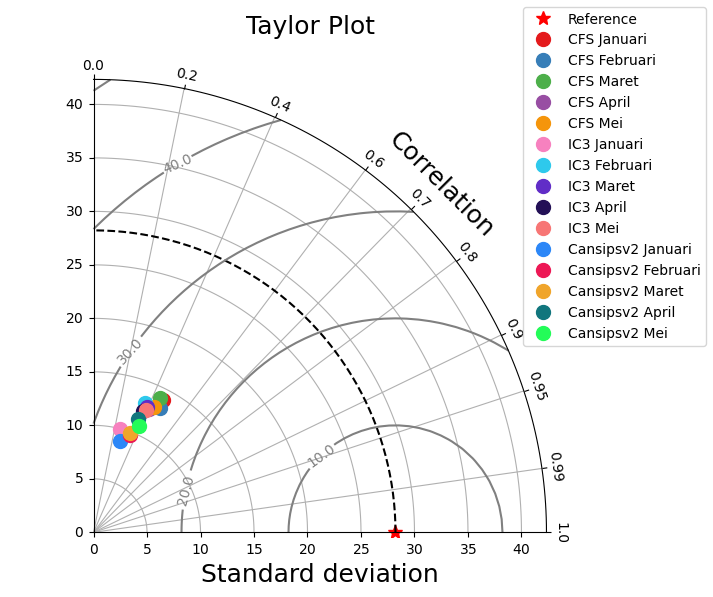

CFS Januari: Standar Deviasi = 13.97, Korelasi = 0.47, RMSE = 0.89, obs = 28.23
CFS Februari: Standar Deviasi = 13.14, Korelasi = 0.47, RMSE = 0.88, obs = 28.23
CFS Maret: Standar Deviasi = 14.06, Korelasi = 0.44, RMSE = 0.90, obs = 28.23
CFS April: Standar Deviasi = 12.65, Korelasi = 0.41, RMSE = 0.91, obs = 28.23
CFS Mei: Standar Deviasi = 12.99, Korelasi = 0.43, RMSE = 0.90, obs = 28.23
IC3 Januari: Standar Deviasi = 9.94, Korelasi = 0.24, RMSE = 0.98, obs = 28.23
IC3 Februari: Standar Deviasi = 12.99, Korelasi = 0.37, RMSE = 0.93, obs = 28.23
IC3 Maret: Standar Deviasi = 12.78, Korelasi = 0.39, RMSE = 0.92, obs = 28.23
IC3 April: Standar Deviasi = 12.25, Korelasi = 0.38, RMSE = 0.93, obs = 28.23
IC3 Mei: Standar Deviasi = 12.41, Korelasi = 0.40, RMSE = 0.92, obs = 28.23
Cansipsv2 Januari: Standar Deviasi = 8.93, Korelasi = 0.28, RMSE = 0.96, obs = 28.23
Cansipsv2 Februari: Standar Deviasi = 9.73, Korelasi = 0.35, RMSE = 0.94, obs = 28.23
Cansipsv2 Maret: Standar Deviasi = 9.92, Kor

In [20]:
import numpy as np
import xarray as xr
from easy_mpl import taylor_plot

# Muat dataset observasi
data_observasi = xr.open_dataset('AMH_with_Median.nc')
obs_var = data_observasi['AMH'].values.flatten()

# Muat dataset prediksi dan flatten datanya
datasets_prediksi = [
    'PreASO_CFSJanuari.nc',
    'PreASO_CFSFebruari.nc',
    'PreASO_CFSMaret.nc',
    'PreASO_CFSApril.nc',
    'PreASO_CFSMei.nc',
    'PreASO_IC3Januari.nc',
    'PreASO_IC3Februari.nc',
    'PreASO_IC3Maret.nc',
    'PreASO_IC3April.nc',
    'PreASO_IC3Mei.nc',
    'PreASO_Cansipv2Januari.nc',
    'PreASO_Cansipv2Februari.nc',
    'PreASO_Cansipv2Maret.nc',
    'PreASO_Cansipv2April.nc',
    'PreASO_Cansipv2Mei.nc'
]

labels = [
    "CFS Januari",
    "CFS Februari",
    "CFS Maret",
    "CFS April",
    "CFS Mei",
    "IC3 Januari",
    "IC3 Februari",
    "IC3 Maret",
    "IC3 April",
    "IC3 Mei",
    "Cansipsv2 Januari",
    "Cansipsv2 Februari",
    "Cansipsv2 Maret",
    "Cansipsv2 April",
    "Cansipsv2 Mei"
]

simulations = {}

for dataset, label in zip(datasets_prediksi, labels):
    data_prediksi = xr.open_dataset(dataset)['AMHp'].values.flatten()
    simulations[label] = data_prediksi

# Hitung standar deviasi dari observasi
std_obs = np.std(obs_var)

# Normalisasi standar deviasi dari prediksi
simulations_normalized = {name: np.std(data) for name, data in simulations.items()}

# Hitung RMSE dan korelasi
rmse = {name: np.sqrt(np.mean((data - obs_var) ** 2)) / std_obs for name, data in simulations.items()}
correlation = {name: np.corrcoef(obs_var, data)[0, 1] for name, data in simulations.items()}

# Buat list untuk Taylor Plot
simulations_data = [
    {
        "name": name,
        "stddev": simulations_normalized[name],
        "corr_coeff": correlation[name],
        "rmse": rmse[name]
    }
    for name in simulations_normalized
]

# Buat Taylor Plot dengan data yang dinormalisasi
_ = taylor_plot(
    observations=obs_var,
    simulations=simulations,
    stddev_normalize=True,
    title="Taylor Plot",
    simulations_data=simulations_data
)

# Cetak hasil untuk validasi
for sim in simulations_data:
    print(f"{sim['name']}: Standar Deviasi = {sim['stddev']:.2f}, Korelasi = {sim['corr_coeff']:.2f}, RMSE = {sim['rmse']:.2f}, obs = {std_obs:.2f}")


In [1]:
import xarray as xr
import numpy as np
from sklearn.metrics import mean_squared_error

# Muat dataset observasi
data_observasi = xr.open_dataset('AMH_with_Median.nc')
obs_var = data_observasi['AMH']

# Muat dataset prediksi untuk beberapa bulan
# data_prediksi1 = xr.open_dataset('predictedCFSJanuariFix.nc')
# data_prediksi2 = xr.open_dataset('predictedCFSFebruari.nc')
# data_prediksi3 = xr.open_dataset('predictedCFSMaret.nc')
# data_prediksi4 = xr.open_dataset('predictedCFSApril.nc')
# data_prediksi5 = xr.open_dataset('predictedCFSMei.nc')
# data_prediksi6 = xr.open_dataset('predictedIC3Januari.nc')
# data_prediksi7 = xr.open_dataset('predictedIC3Februari.nc')
# data_prediksi8 = xr.open_dataset('predictedIC3Maret.nc')
# data_prediksi9 = xr.open_dataset('predictedIC3April.nc')
# data_prediksi10 = xr.open_dataset('predictedIC3Mei.nc')
# data_prediksi11 = xr.open_dataset('predictedCansipsv2Januari.nc')
# data_prediksi12 = xr.open_dataset('predictedCansipsv2Februari.nc')
# data_prediksi13 = xr.open_dataset('predictedCansipsv2Maret.nc')
# data_prediksi14 = xr.open_dataset('predictedCansipsv2April.nc')
# data_prediksi15 = xr.open_dataset('predictedCansipsv2Mei.nc')

data_prediksi1 = xr.open_dataset('PreASO_CFSJanuari.nc')
data_prediksi2 = xr.open_dataset('PreASO_CFSFebruari.nc')
data_prediksi3 = xr.open_dataset('PreASO_CFSMaret.nc')
data_prediksi4 = xr.open_dataset('PreASO_CFSApril.nc')
data_prediksi5 = xr.open_dataset('PreASO_CFSMei.nc')
data_prediksi6 = xr.open_dataset('PreASO_IC3Januari.nc')
data_prediksi7 = xr.open_dataset('PreASO_IC3Februari.nc')
data_prediksi8 = xr.open_dataset('PreASO_IC3Maret.nc')
data_prediksi9 = xr.open_dataset('PreASO_IC3April.nc')
data_prediksi10 = xr.open_dataset('PreASO_IC3Mei.nc')
data_prediksi11 = xr.open_dataset('PreASO_Cansipv2Januari.nc')
data_prediksi12 = xr.open_dataset('PreASO_Cansipv2Februari.nc')
data_prediksi13 = xr.open_dataset('PreASO_Cansipv2Maret.nc')
data_prediksi14 = xr.open_dataset('PreASO_Cansipv2April.nc')
data_prediksi15 = xr.open_dataset('PreASO_Cansipv2Mei.nc')

# Sesuaikan dengan variabel dari dataset prediksi
pred_vars = [data_prediksi1['AMHp'], data_prediksi2['AMHp'], data_prediksi3['AMHp'],
             data_prediksi4['AMHp'], data_prediksi5['AMHp'], data_prediksi6['AMHp'],
             data_prediksi7['AMHp'], data_prediksi8['AMHp'], data_prediksi9['AMHp'],
             data_prediksi10['AMHp'], data_prediksi11['AMHp'], data_prediksi12['AMHp'],
             data_prediksi13['AMHp'], data_prediksi14['AMHp'], data_prediksi15['AMHp']]

# Fungsi untuk menghitung RMSE (Root Mean Square Error)
def calculate_rmse(obs, pred):
    if np.any(np.isnan(obs)) or np.any(np.isnan(pred)):
        return np.nan
    else:
        return np.sqrt(mean_squared_error(obs, pred))

# Tentukan dimensi dan koordinat
latitudes = obs_var['latitude']
longitudes = obs_var['longitude']

# Buat array untuk menyimpan hasil RMSE
rmse_maps = [np.zeros((len(latitudes), len(longitudes))) for _ in range(15)]

# Hitung RMSE untuk setiap bulan
for idx, pred_var in enumerate(pred_vars):
    for i in range(len(latitudes)):
        for j in range(len(longitudes)):
            obs_data = obs_var[:, i, j].values
            pred_data = pred_var[:, i, j].values
            rmse_maps[idx][i, j] = calculate_rmse(obs_data, pred_data)

# rmse_maps sekarang berisi nilai RMSE antara data observasi dan data prediksi untuk setiap bulan


In [2]:
import xarray as xr
import numpy as np

# Anggap data observasi dan data prediksi sudah di-load seperti sebelumnya

# Definisikan koordinat
latitudes = obs_var['latitude']
longitudes = obs_var['longitude']
months = ['Januari', 'Februari', 'Maret', 'April', 'Mei']

# Buat data array untuk korelasi, dengan bentuk [bulan, latitude, longitude]
rmse_data = np.stack(rmse_maps).reshape((15, len(latitudes), len(longitudes)))

# Buat dataset xarray
rmse_dataset = xr.Dataset(
    {
        'rmse': (['month', 'latitude', 'longitude'], rmse_data)
    },
    coords={
        'month': months * 3,  # 15 bulan karena 3 model (5 bulan per model)
        'latitude': latitudes,
        'longitude': longitudes
    }
)

# Simpan dataset ke file NetCDF
# rmse_dataset.to_netcdf('rmse_results.nc')
dataaslireal = xr.open_dataset('AMH_with_NAN.nc')
mask = dataaslireal['AMH'][:15,:,:]
mask_nan_var7 = np.isnan(mask)
rmse_dataset = rmse_dataset['rmse'].values
rmse_dataset[mask_nan_var7] = np.nan

# Buat dataset xarray
rmse_dataset = xr.Dataset(
    {
        'rmse': (['month', 'latitude', 'longitude'], rmse_dataset)
    },
    coords={
        'month': months * 3,  # 15 bulan karena 3 model (5 bulan per model)
        'latitude': latitudes,
        'longitude': longitudes
    }
)
# Simpan dataset ke file NetCDF
rmse_dataset.to_netcdf('rmse_results_ASO.nc')

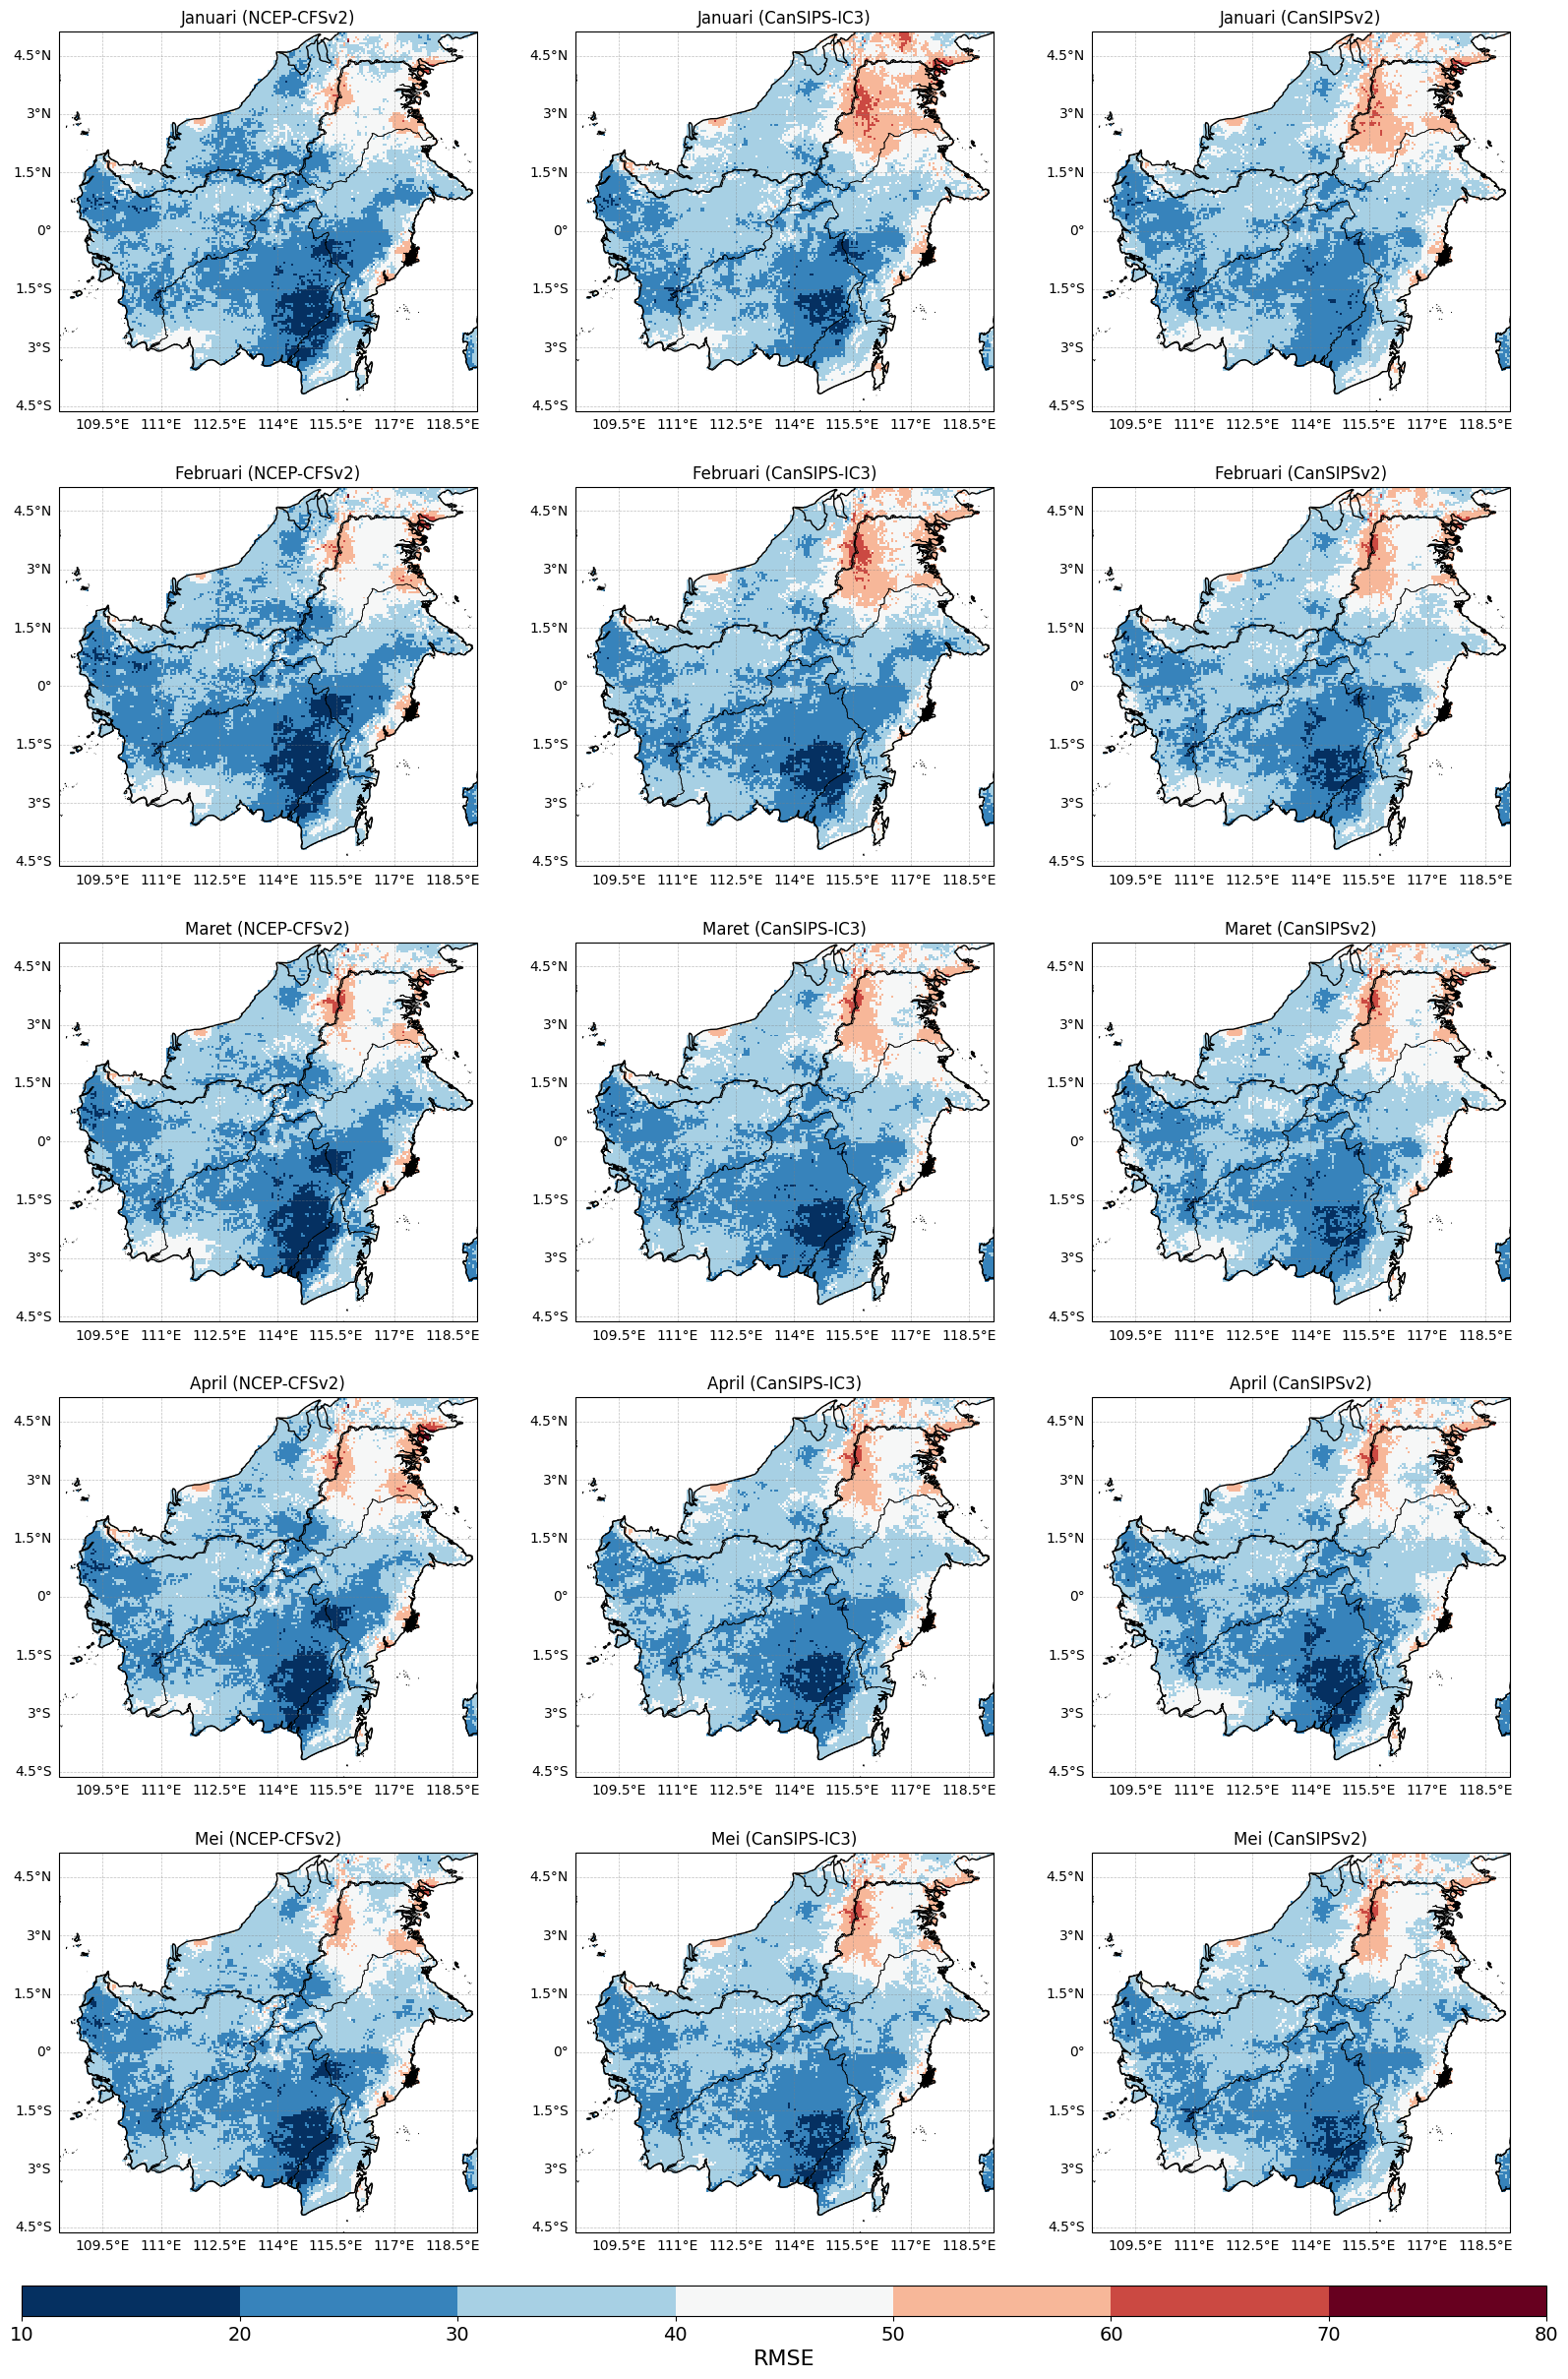

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import BoundaryNorm
# Muat dataset hasil korelasi
correlation_dataset = xr.open_dataset('rmse_results_ASO.nc')

# Ekstrak data dari dataset
latitude = correlation_dataset.latitude.values
longitude = correlation_dataset.longitude.values
months = correlation_dataset.month.values
correlation_data = correlation_dataset.rmse.values

# Tentukan model untuk visualisasi
num_models = 3
num_months = 5
model_names = ["NCEP-CFSv2", "CanSIPS-IC3", "CanSIPSv2"]

# Buat figure dan axes untuk subplot
# fig, axes = plt.subplots(num_months, num_models, figsize=(30, 25), subplot_kw={'projection': ccrs.PlateCarree()})

# Buat figure dan axes untuk subplot dengan jarak antar subplot yang lebih kecil
fig, axes = plt.subplots(num_months, num_models, figsize=(20, 35), subplot_kw={'projection': ccrs.PlateCarree()}, 
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.05})


# Atur warna dan batas warna
cmap = plt.cm.RdBu_r 
levels = np.arange(10, 90, 10)  # Batas warna per 10 unit dari -100 hingga 100
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Inisialisasi variabel untuk menyimpan nilai minimum dan maksimum RMSE
global_min_rmse = np.inf
global_max_rmse = -np.inf



# Load shapefile batas provinsi
shapefile_path = 'BATAS_PROVINSI_DESEMBER_2019_DUKCAPIL.shp'  # Ganti dengan path ke shapefile
gdf = gpd.read_file(shapefile_path)

# Filter shapefile sesuai dengan batas longitude dan latitude dari dataset korelasi
lon_min, lon_max = np.min(longitude), np.max(longitude)
lat_min, lat_max = np.min(latitude), np.max(latitude)
gdf = gdf.cx[lon_min:lon_max, lat_min:lat_max]

# Proyeksikan shapefile ke Plate Carree jika belum dalam format yang sesuai
gdf = gdf.to_crs(ccrs.PlateCarree().proj4_init)


# Iterasi melalui setiap bulan dan model
for i, month in enumerate(months):
    row = i % num_months
    col = i // num_months
    ax = axes[row, col]
    # Hitung nilai minimum dan maksimum RMSE untuk bulan ini
    local_min_rmse = np.nanmin(correlation_data)
    local_max_rmse = np.nanmax(correlation_data)

    # Update nilai minimum dan maksimum global RMSE
    global_min_rmse = min(global_min_rmse, local_min_rmse)
    global_max_rmse = max(global_max_rmse, local_max_rmse)
    # Plot korelasi untuk setiap model dan bulan
    correlation = correlation_data[i, :, :]  # Mengambil data untuk bulan tertentu
    
    # Menambahkan data pada peta
    mesh = ax.pcolormesh(longitude, latitude, correlation, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())
    
    # Menambahkan fitur geografis
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    
    # Plot batas provinsi dari shapefile menggunakan GeoPandas
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree())
    # Menambahkan gridline dan label
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Tambahkan label bulan dan model
    ax.set_title(f'{month} ({model_names[col]})', fontsize=12)
        
    # Set extent plot berdasarkan lon dan lat dari data korelasi
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


# Sesuaikan layout subplot secara manual
plt.subplots_adjust(wspace=0.001, hspace=0.001)

# Tambahkan colorbar di bawah subplot
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02, aspect=50)
cbar.set_label('RMSE', fontsize=16)
# Perbesar teks pada colorbar
cbar.ax.tick_params(labelsize=14)

# Sesuaikan layout dan simpan gambar
# plt.tight_layout()
# plt.savefig('correlation_maps_cartopy.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Visualisasi korelasi telah disimpan ke 'correlation_maps_cartopy.png'")


In [5]:
import xarray as xr
import numpy as np

# Muat dataset observasi
data_observasi = xr.open_dataset('AMH_with_Median.nc')
obs_var = data_observasi['AMH']

# Muat dataset prediksi untuk beberapa bulan

data_prediksi1 = xr.open_dataset('PreASO_CFSJanuari.nc')
data_prediksi2 = xr.open_dataset('PreASO_CFSFebruari.nc')
data_prediksi3 = xr.open_dataset('PreASO_CFSMaret.nc')
data_prediksi4 = xr.open_dataset('PreASO_CFSApril.nc')
data_prediksi5 = xr.open_dataset('PreASO_CFSMei.nc')
data_prediksi6 = xr.open_dataset('PreASO_IC3Januari.nc')
data_prediksi7 = xr.open_dataset('PreASO_IC3Februari.nc')
data_prediksi8 = xr.open_dataset('PreASO_IC3Maret.nc')
data_prediksi9 = xr.open_dataset('PreASO_IC3April.nc')
data_prediksi10 = xr.open_dataset('PreASO_IC3Mei.nc')
data_prediksi11 = xr.open_dataset('PreASO_Cansipv2Januari.nc')
data_prediksi12 = xr.open_dataset('PreASO_Cansipv2Februari.nc')
data_prediksi13 = xr.open_dataset('PreASO_Cansipv2Maret.nc')
data_prediksi14 = xr.open_dataset('PreASO_Cansipv2April.nc')
data_prediksi15 = xr.open_dataset('PreASO_Cansipv2Mei.nc')

# Sesuaikan dengan variabel dari dataset prediksi
pred_vars = [data_prediksi1['AMHp'], data_prediksi2['AMHp'], data_prediksi3['AMHp'],
             data_prediksi4['AMHp'], data_prediksi5['AMHp'], data_prediksi6['AMHp'],
             data_prediksi7['AMHp'], data_prediksi8['AMHp'], data_prediksi9['AMHp'],
             data_prediksi10['AMHp'], data_prediksi11['AMHp'], data_prediksi12['AMHp'],
             data_prediksi13['AMHp'], data_prediksi14['AMHp'], data_prediksi15['AMHp']]

# Tentukan dimensi dan koordinat
latitudes = obs_var['latitude']
longitudes = obs_var['longitude']

# Buat array untuk menyimpan hasil standar deviasi yang dinormalisasi
normalized_std_maps = [np.zeros((len(latitudes), len(longitudes))) for _ in range(15)]

# Hitung standar deviasi yang dinormalisasi untuk setiap bulan
for idx, pred_var in enumerate(pred_vars):
    for i in range(len(latitudes)):
        for j in range(len(longitudes)):
            obs_data = obs_var[:, i, j].values
            pred_data = pred_var[:, i, j].values
            
            # Hitung standar deviasi
            std_obs = np.std(obs_data)
            std_pred = np.std(pred_data)
            
            # Hindari pembagian dengan nol dan NaN
            if std_obs == 0 or np.isnan(std_obs):
                normalized_std_maps[idx][i, j] = np.nan
            else:
                normalized_std_maps[idx][i, j] = std_pred / std_obs

# normalized_std_maps sekarang berisi nilai standar deviasi yang dinormalisasi antara data observasi dan data prediksi untuk setiap bulan


In [6]:
import xarray as xr
import numpy as np

# Anggap data observasi dan data prediksi sudah di-load seperti sebelumnya

# Definisikan koordinat
latitudes = obs_var['latitude']
longitudes = obs_var['longitude']
months = ['Januari', 'Februari', 'Maret', 'April', 'Mei']

# Buat data array untuk korelasi, dengan bentuk [bulan, latitude, longitude]
stdev_data = np.stack(normalized_std_maps).reshape((15, len(latitudes), len(longitudes)))

# Buat dataset xarray
stdev_dataset = xr.Dataset(
    {
        'stdev': (['month', 'latitude', 'longitude'], stdev_data)
    },
    coords={
        'month': months * 3,  # 15 bulan karena 3 model (5 bulan per model)
        'latitude': latitudes,
        'longitude': longitudes
    }
)

# Simpan dataset ke file NetCDF
stdev_dataset.to_netcdf('stdev_results_ASO.nc')

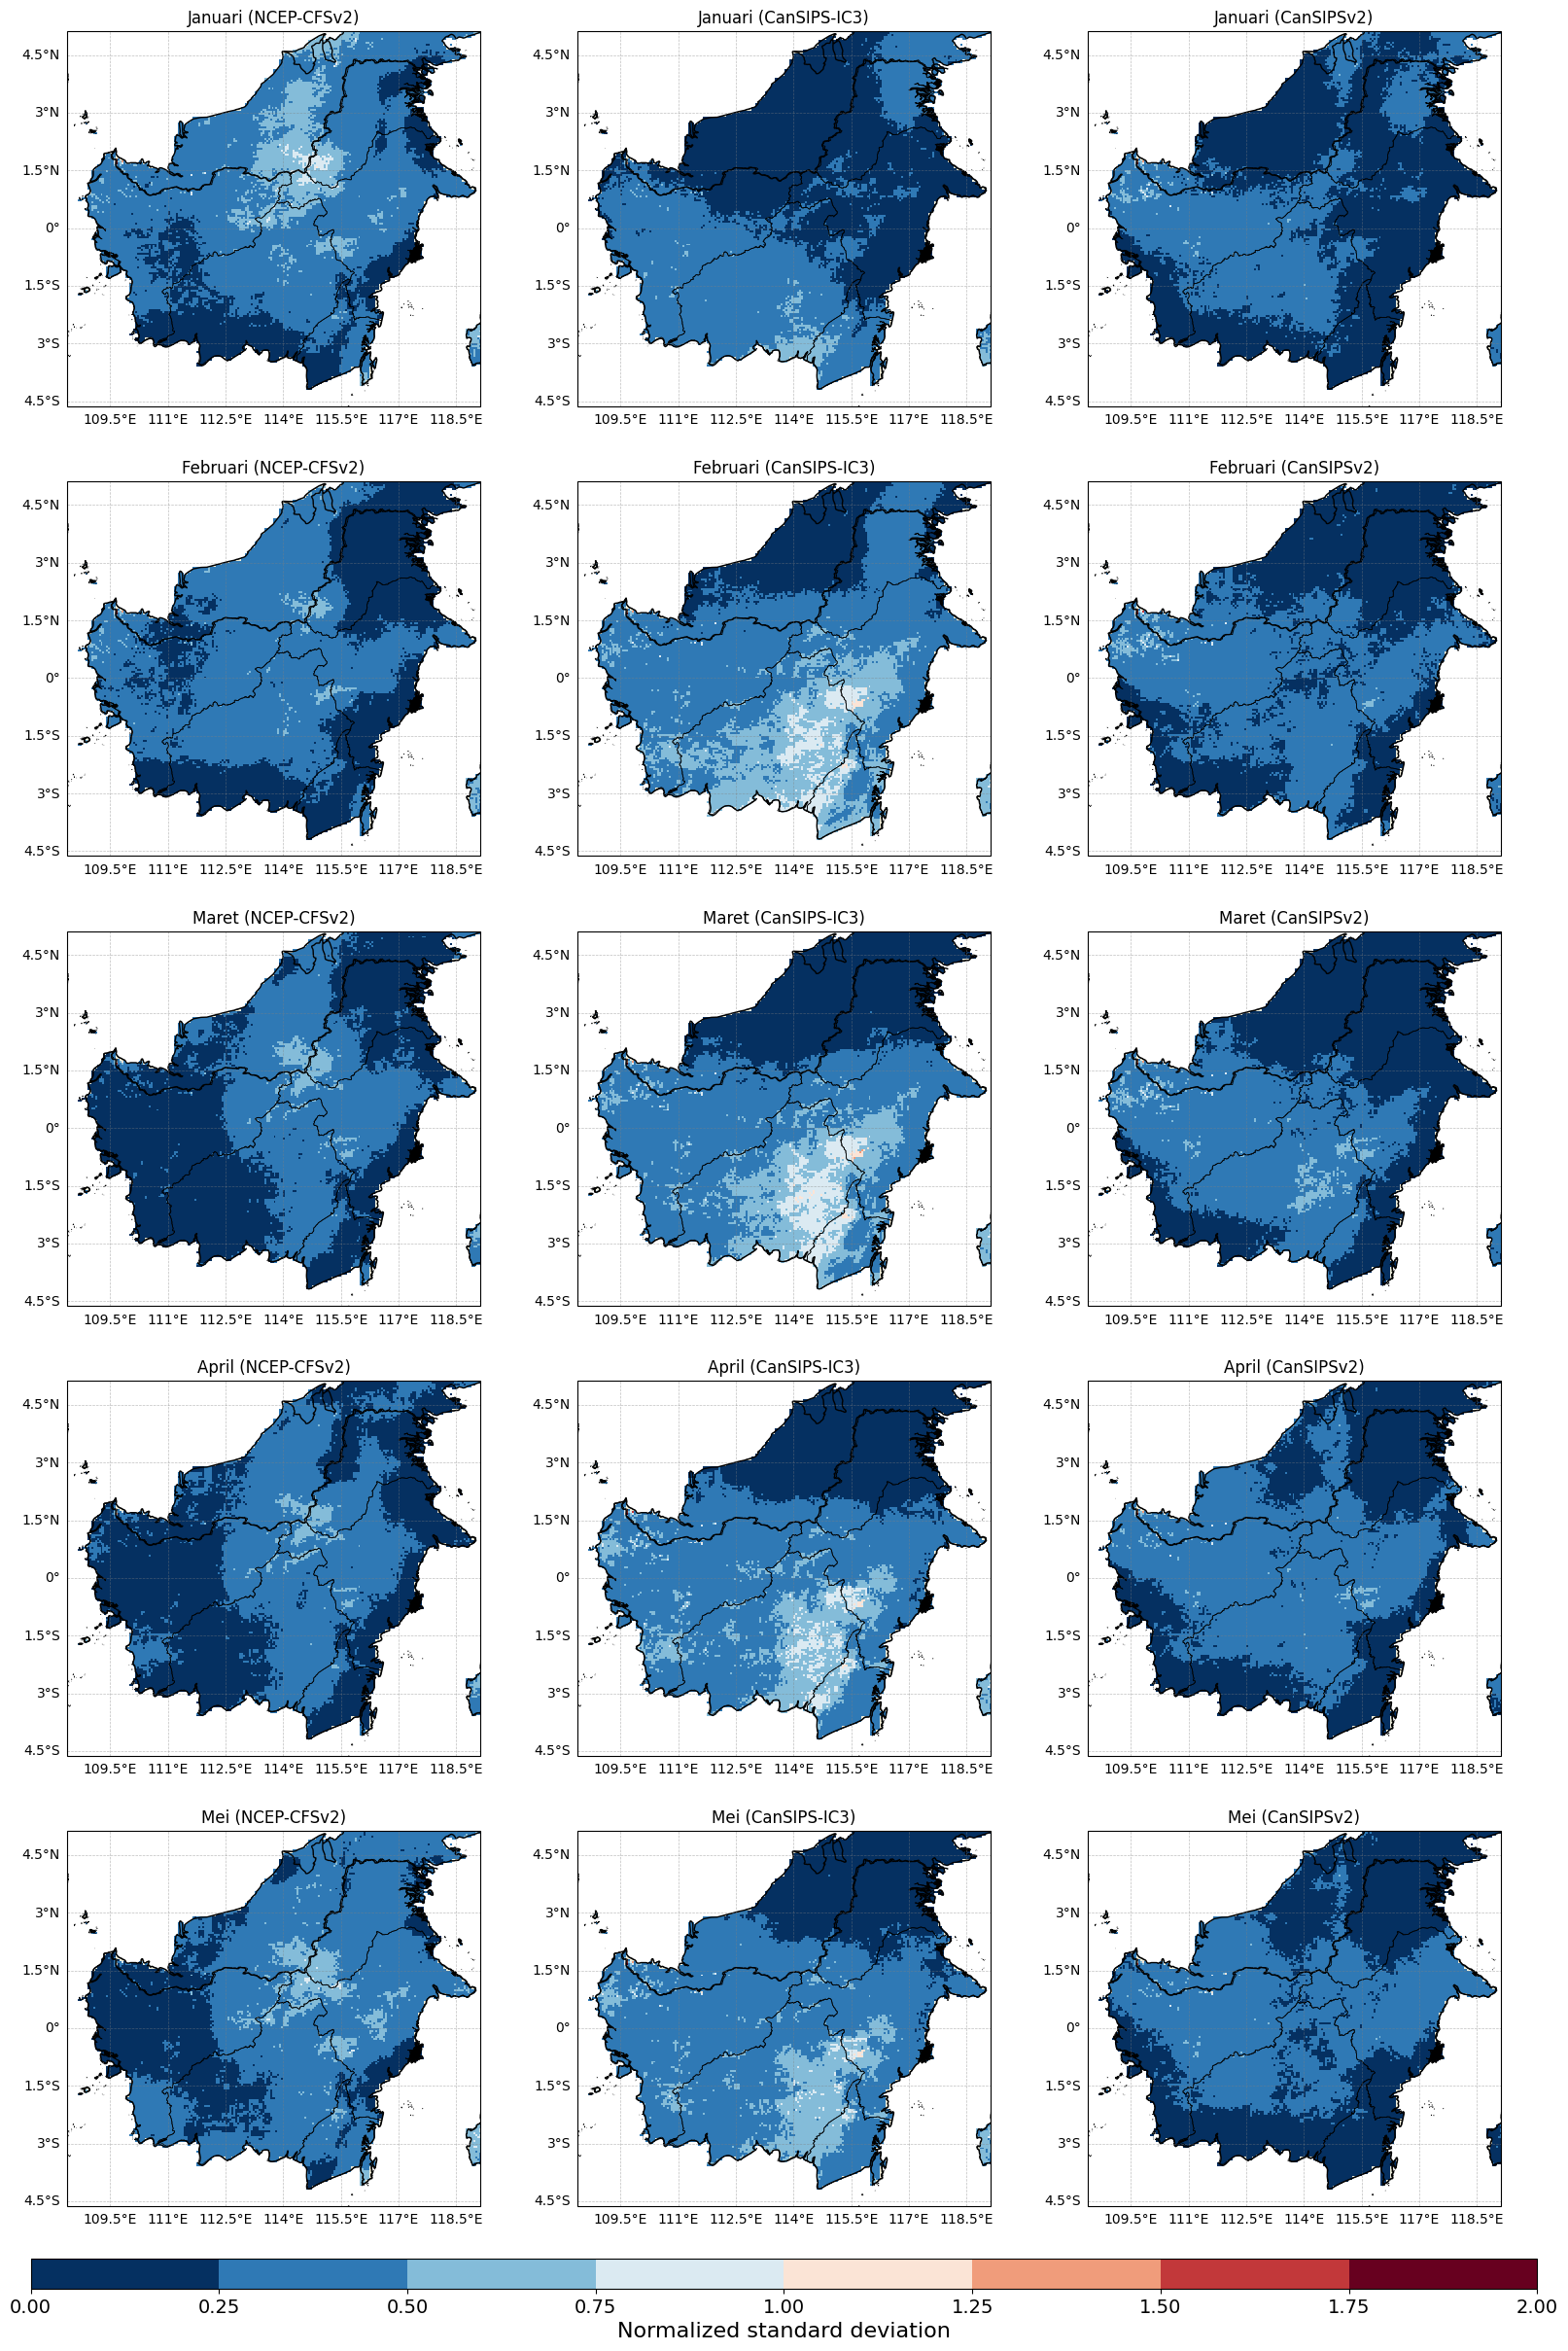

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.colors as mcolors


# Muat dataset hasil korelasi
correlation_dataset = xr.open_dataset('stdev_results_ASO.nc')

# Ekstrak data dari dataset
latitude = correlation_dataset.latitude.values
longitude = correlation_dataset.longitude.values
months = correlation_dataset.month.values
correlation_data = correlation_dataset.stdev.values

# Tentukan model untuk visualisasi
num_models = 3
num_months = 5
model_names = ["NCEP-CFSv2", "CanSIPS-IC3", "CanSIPSv2"]

# Buat figure dan axes untuk subplot
# fig, axes = plt.subplots(num_months, num_models, figsize=(30, 25), subplot_kw={'projection': ccrs.PlateCarree()})

# Buat figure dan axes untuk subplot dengan jarak antar subplot yang lebih kecil
fig, axes = plt.subplots(num_months, num_models, figsize=(20, 35), subplot_kw={'projection': ccrs.PlateCarree()}, 
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.05})


# Load shapefile batas provinsi
shapefile_path = 'BATAS_PROVINSI_DESEMBER_2019_DUKCAPIL.shp'  # Ganti dengan path ke shapefile
gdf = gpd.read_file(shapefile_path)

# Filter shapefile sesuai dengan batas longitude dan latitude dari dataset korelasi
lon_min, lon_max = np.min(longitude), np.max(longitude)
lat_min, lat_max = np.min(latitude), np.max(latitude)
gdf = gdf.cx[lon_min:lon_max, lat_min:lat_max]

# Proyeksikan shapefile ke Plate Carree jika belum dalam format yang sesuai
gdf = gdf.to_crs(ccrs.PlateCarree().proj4_init)

# Atur warna dan batas warna
cmap = plt.cm.RdBu_r 
levels = np.arange(0, 2.25, 0.25)  # Batas warna per 10 unit dari -100 hingga 100
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# bounds = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]
# norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Inisialisasi variabel untuk menyimpan nilai minimum dan maksimum RMSE
global_min_rmse = np.inf
global_max_rmse = -np.inf

# Iterasi melalui setiap bulan dan model
for i, month in enumerate(months):
    row = i % num_months
    col = i // num_months
    ax = axes[row, col]
    # Hitung nilai minimum dan maksimum RMSE untuk bulan ini
    local_min_rmse = np.nanmin(correlation_data)
    local_max_rmse = 2

    # Update nilai minimum dan maksimum global RMSE
    # global_min_rmse = min(global_min_rmse, local_min_rmse)
    # global_max_rmse = max(global_max_rmse, local_max_rmse)
    # Plot korelasi untuk setiap model dan bulan
    correlation = correlation_data[i, :, :]  # Mengambil data untuk bulan tertentu
    
    # Menambahkan data pada peta
    mesh = ax.pcolormesh(longitude, latitude, correlation, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())
    
    # Menambahkan fitur geografis
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    
    # Plot batas provinsi dari shapefile menggunakan GeoPandas
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree())
    # Menambahkan gridline dan label
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Tambahkan label bulan dan model
    ax.set_title(f'{month} ({model_names[col]})', fontsize=12)
        
    # Set extent plot berdasarkan lon dan lat dari data korelasi
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


# Sesuaikan layout subplot secara manual
plt.subplots_adjust(wspace=0.001, hspace=0.001)

# Tambahkan colorbar di bawah subplot
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02, aspect=50)
cbar.set_label('Normalized standard deviation', fontsize=16)
# Perbesar teks pada colorbar
cbar.ax.tick_params(labelsize=14)

# Sesuaikan layout dan simpan gambar
# plt.tight_layout()
# plt.savefig('correlation_maps_cartopy.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Visualisasi korelasi telah disimpan ke 'correlation_maps_cartopy.png'")
